In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42

Populating the interactive namespace from numpy and matplotlib


In [2]:
import group_data as gd
flylist = gd.swarms['GMR22H05_yr'].flies

In [3]:
trial_list = ['step_roll_yaw_%03d'%(i) for i in range(0,360,30)]
trial_to_label = dict()
[trial_to_label.update({tname:str(lbl)}) for tname,lbl in zip(trial_list,range(0,360,30))]
trial_to_label['step_roll_yaw_000'] = 'RL\n00'
trial_to_label['step_roll_yaw_090'] = 'YR\n90'
trial_to_label['step_roll_yaw_180'] = 'RR\n180'
trial_to_label['step_roll_yaw_270'] = 'YL\n270'
trial_to_label

{'step_roll_yaw_000': 'RL\n00',
 'step_roll_yaw_030': '30',
 'step_roll_yaw_060': '60',
 'step_roll_yaw_090': 'YR\n90',
 'step_roll_yaw_120': '120',
 'step_roll_yaw_150': '150',
 'step_roll_yaw_180': 'RR\n180',
 'step_roll_yaw_210': '210',
 'step_roll_yaw_240': '240',
 'step_roll_yaw_270': 'YL\n270',
 'step_roll_yaw_300': '300',
 'step_roll_yaw_330': '330'}

In [4]:
flylist = [fly for fly in flylist if not(fly.fly_num == 648)]

In [5]:
[fly.fly_num for fly in flylist]

[656, 657, 658, 659, 660, 661, 662]

In [12]:
data_dict = dict()

signal_dict = dict()
[signal_dict.update({tname:list()}) for tname in trial_list]
sig_name = 'Ph1'

for fly in flylist:
    print fly.fly_num
    fly.open_fly_record()
    import os
    os.listdir(fly.fly_path)
    data = fly.get_pkl_data('nnls_fits_bk_sub_F_sig_mtrx.cpkl')

    for i,trial_type in enumerate(trial_list):
        #sca(axlist[i])
        selection = data['trial_cond'] == trial_type
        #flight_mask = np.nansum(data['wb_frequency']>150,axis = 1)>800
        #selection *= flight_mask
        signals = data[sig_name][selection]
        bsline = np.nanmean(signals[:,100:300])
        if np.isnan(bsline):
            bsline = 0
        #print bsline
        signal = np.nanmean(signals,axis = 0)-bsline
        signal_dict[trial_type].append(signal)
data_dict[sig_name] = signal_dict


signal_dict = dict()
[signal_dict.update({tname:list()}) for tname in trial_list]
sig_name = 'i1'

for fly in flylist:
    print fly.fly_num
    fly.open_fly_record()
    import os
    os.listdir(fly.fly_path)
    data = fly.get_pkl_data('nnls_fits_bk_sub_F_sig_mtrx.cpkl')

    for i,trial_type in enumerate(trial_list):
        #sca(axlist[i])
        selection = data['trial_cond'] == trial_type
        #flight_mask = np.nansum(data['wb_frequency']>150,axis = 1)>800
        #selection *= flight_mask
        signals = data[sig_name][selection]
        bsline = np.nanmean(signals[:,100:300])
        if np.isnan(bsline):
            bsline = 0
        #print bsline
        signal = np.nanmean(signals,axis = 0)-bsline
        signal_dict[trial_type].append(signal)
data_dict[sig_name] = signal_dict

656
657
658
659
660
661
662
656
657
658
659
660
661
662


In [13]:
def fly_means(data,mask):
    xi = np.linspace(0,23,1150)
    baseline_epoch = (xi >5) & (xi < 7)
    ave_dict = dict()
    signal_set = set(data['signal_names'][mask])
    trial_set = set(data['trial_names'][mask])
    fly_set = set(data['fly_numbers'][mask])
    for signal in signal_set:
        ave_dict[signal] = dict()
        for trial in trial_set:
            ave_dict[signal][trial] = list()
            for fly in fly_set:
                selection = (data['fly_numbers'] == fly) & \
                            (data['signal_names'] == signal) & \
                            (data['trial_names'] == trial) & \
                            mask
                datamtrx = data['signal_data'][selection,:] 
                baseline = np.mean(data['signal_data'][selection][:,baseline_epoch],axis = 1)
                datamtrx -= baseline[:,np.newaxis]
                ave_dict[signal][trial].append(np.nanmedian(datamtrx,axis = 0)) 
    return ave_dict

In [14]:
def resample_ts_ci(dataset,nsamples = 100):
    synthetic_means = np.zeros([nsamples,shape(dataset)[1]])
    idxs = np.arange(shape(dataset)[0])
    for i in range(nsamples):
        synthetic_means[i,:] = np.mean(dataset[np.random.choice(idxs,size = len(idxs)),:],axis = 0)
    ub = np.nanpercentile(synthetic_means,95,axis = 0)
    lb = np.nanpercentile(synthetic_means,5,axis = 0)
    mean = np.mean(dataset,axis =0)
    return ub,lb,mean

In [15]:
def plot_mean_std(col,row):
    xi = np.linspace(0,23,1150)
    sel = (xi>4) & (xi<12)
    sig_key = sig_list[row]
    trial_key = trial_list[col]
    n= np.shape(data_dict[sig_key][trial_key])[0]
    ub,lb,md = resample_ts_ci(np.array(data_dict[sig_key][trial_key]))
    md,ub,lb = [gd.signal_plot_info[sig_key]['transform'](x) for x in (md,ub,lb)]
    fill_between(xi[sel],ub[sel],lb[sel],alpha = 0.5,lw = 0,clip_on = False, color = 'k')
    plot(xi[sel],md[sel],clip_on = False,color = 'k')

In [19]:
trial_list
sig_list = ['Ph1','i1']

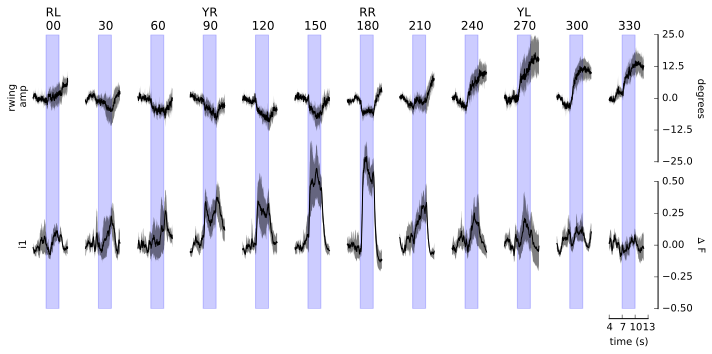

In [20]:
rows = len(sig_list)
cols = len(trial_list)

col_epochs = [(7,10) for i in range(cols)]
row_epochs = [None for j in range(rows)]

col_labels_bottom = [None for i in range(cols)] 
col_labels_bottom[-1] = 'time (s)'
row_labels_left = [gd.signal_plot_info[sig]['ax_label'] for sig in sig_list]

col_labels_top = [trial_to_label[trial] for trial in trial_list]
#row_labels_right = [None for j in range(rows)]
row_labels_right = ['degrees',u'$\u0394$ F']

ybounds = [(-25,25),(-0.5,0.5)]
xbounds = [(4,13) for i in range(cols)]

ytick_numbers = [5 for j in range(rows)]
xtick_numbers = [4 for i in range(cols)]

show_spines_left = False
show_spines_right = [True for j in range(rows)]

show_spines_top = False
show_spines_bottom = [False for j in range(cols)]
show_spines_bottom[-1] = True

import plotfuncs as pf
reload(pf)

pf.plot_data_matrix(rows = rows,
                cols = cols,
                col_epochs = col_epochs,
                row_epochs = row_epochs,
                col_labels_bottom = col_labels_bottom,
                row_labels_left = row_labels_left,
                col_labels_top = col_labels_top,
                row_labels_right = row_labels_right,
                ybounds = ybounds,
                xbounds = xbounds,
                xtick_numbers = xtick_numbers,
                ytick_numbers = ytick_numbers,
                show_spines_left = show_spines_left,
                show_spines_right = show_spines_right,
                show_spines_top = show_spines_top,
                show_spines_bottom = show_spines_bottom,
                plot_panel_function = plot_mean_std);